# Example for consensus
This notebook demonstrates a weighted-matrix-based consensus implementation.
This experiment utilizes processes as computing nodes.

## 1. Set some global parameters:

In [4]:
if __name__ == "__main__":
    N_STATE = 3
    N_NODES = 5

## 2. Deploy the nodes using multiprocessing:
Here, we use the consensus iteration formula:
$$
x(k+1) = W x(k),
$$
where $W$ is the mixing matrix of the graph, as defined in task `graph_server`.

In [5]:
from multiprocessing import Pool
from numpy import float64
from numpy.typing import NDArray


def graph_server() -> None:
    from logging import basicConfig, INFO

    basicConfig(level=INFO)

    from numpy import array, eye
    from topolink import Graph

    L = array(
        [
            [2, -1, 0, 0, -1],
            [-1, 2, -1, 0, 0],
            [0, -1, 2, -1, 0],
            [0, 0, -1, 2, -1],
            [-1, 0, 0, -1, 2],
        ]
    )
    W = eye(5) - L * 0.45

    graph = Graph.from_mixing_matrix(W)

    graph.deploy()


def laplacian_consensus(name: str, n_state: int, n_iter: int = 50) -> NDArray[float64]:
    from numpy import zeros
    from numpy.random import uniform, seed
    from topolink import NodeHandle

    nh = NodeHandle(name)

    states = zeros((n_iter, n_state))
    seed(int(name))  # Ensure reproducibility for each node
    states[0] = uniform(-100.0, 100.0, n_state)

    for k in range(n_iter - 1):
        states[k + 1] = nh.weighted_mix(states[k])

    return states


if __name__ == "__main__":
    with Pool(N_NODES + 1) as pool:
        server = pool.apply_async(graph_server)
        tasks = [
            pool.apply_async(laplacian_consensus, args=(str(i + 1), N_STATE))
            for i in range(N_NODES)
        ]
        node_states = [task.get() for task in tasks]
        server.get()

INFO:topolink.graph:Graph 'default' running on: 172.26.120.171:41853
INFO:topolink.discovery:Registered graph service with name default
INFO:topolink.graph:Node 3 joined graph 'default' from 172.26.120.171:35277.
INFO:topolink.graph:Node 1 joined graph 'default' from 172.26.120.171:36893.
INFO:topolink.graph:Node 2 joined graph 'default' from 172.26.120.171:33865.
INFO:topolink.graph:Node 4 joined graph 'default' from 172.26.120.171:41579.
INFO:topolink.graph:Node 5 joined graph 'default' from 172.26.120.171:46541.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor information to all nodes in graph 'default'.
INFO:topolink.discovery:Unregistered graph service with name default


**Note:**
The order in which the nodes and server are started does not affect the overall program.

## 3. Plot the results:

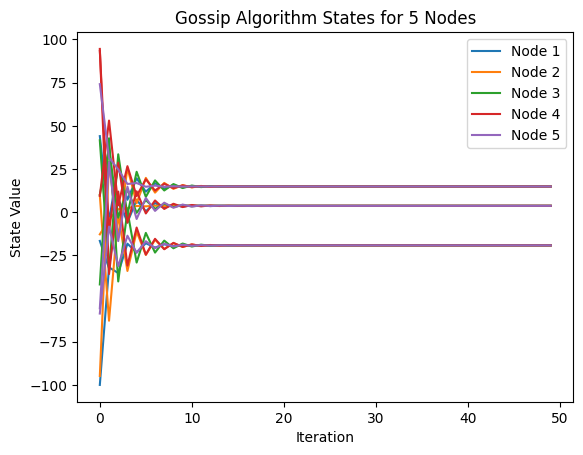

In [6]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    _, ax = plt.subplots()

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

    for i in range(N_NODES):
        states = node_states[i]
        for j in range(N_STATE):
            (line,) = ax.plot(states[:, j], color=colors[i])
            line.set_label(f"Node {i + 1}") if j == 0 else None

    ax.set_xlabel("Iteration")
    ax.set_ylabel("State Value")
    ax.legend()
    ax.set_title(f"Gossip Algorithm States for {N_NODES} Nodes")

    plt.show()